# BINGO Hackaton - Lecture 05

**Luciano Barosi**

*BINGO Collaboration*

## Fast Fourier Transform and Applications

In [1]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

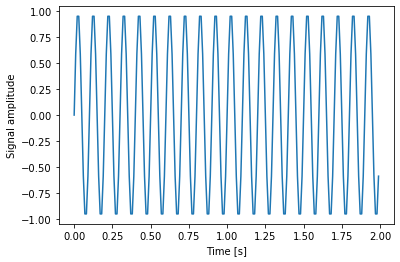

In [2]:
# Building an harmonic signal
f = 10  # Frequency, in cycles per second, or Hertz
f_s = 100  # Sampling rate, or number of measurements per second

t = np.linspace(0, 2, 2 * f_s, endpoint=False)
x = np.sin(f * 2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, x)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal amplitude');

(-5, 110)

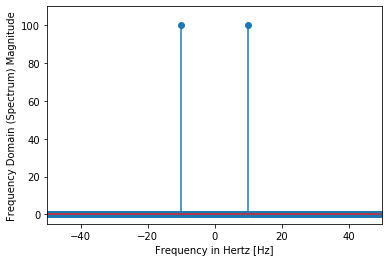

In [5]:
from scipy import fftpack

X = fftpack.fft(x)
freqs = fftpack.fftfreq(len(x)) * f_s

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X), use_line_collection = True)
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-f_s / 2, f_s / 2)
ax.set_ylim(-5, 110)

We want to study signals and decompose them in their constituent frequencies.

In [17]:
from IPython.display import Audio
file = "../DATA/Nightingale-sound.wav"
Audio(file)

In [20]:
from scipy.io import wavfile

rate, audio = wavfile.read(file)
print(rate)


44100


Audio length: 30.51 seconds


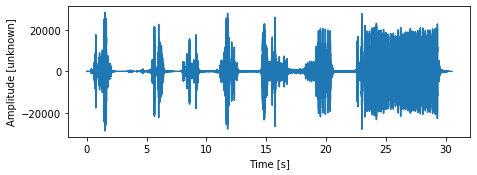

In [29]:
N = audio.shape[0]
L = N / rate

print(f'Audio length: {L:.2f} seconds')

f, ax = plt.subplots(figsize=(7.2, 2.4))
ax.plot(np.arange(N) / rate, audio)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude [unknown]');

In order to understand better the signal we are going to construct a moving window of length 1024 samples, each one 100 samples apart. It is important that the size of the windows is a multiple of 2.

In [24]:
from skimage import util
M = 1024

slices = util.view_as_windows(audio, window_shape = (M,), step = 100)
print(f'Audio shape: {audio.shape}, Sliced audio shape: {slices.shape}')

Audio shape: (1345536,), Sliced audio shape: (13446, 1024)


In [25]:
# Construct a Hanning window
win = np.hanning(M + 1)[:-1]
slices = slices * win
# Transpose
slices = slices.T
print('Shape of `slices`:', slices.shape)
# DFT for each slice
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)


Shape of `slices`: (1024, 13446)


/opt/conda/envs/cosmos3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


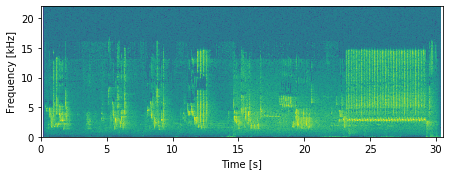

In [27]:
f, ax = plt.subplots(figsize=(7.2, 2.4))

S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, L, 0, rate / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

/opt/conda/envs/cosmos3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


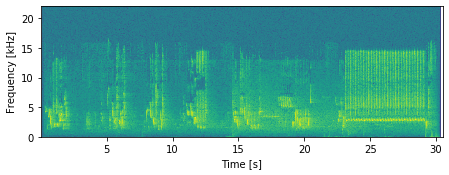

In [28]:
from scipy import signal

freqs, times, Sx = signal.spectrogram(audio, fs=rate, window='hanning',
                                      nperseg=1024, noverlap=M - 100,
                                      detrend=False, scaling='spectrum')

f, ax = plt.subplots(figsize=(7.2, 2.4))
ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

### Noisy Signal

In [30]:
# Create a signal
seed = 1000
time_step = 0.02
period = 5.

time_vec = np.arange(0,20,time_step)
signal = (np.sin(2*np.pi/period * time_vec) 
          + 0.5 * np.random.randn(time_vec.size))


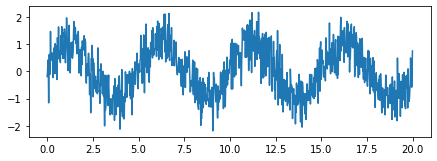

In [33]:
# Plot the signal
plt.figure(figsize=(7.2, 2.4))
plt.plot(time_vec, signal, label='Original signal')

True


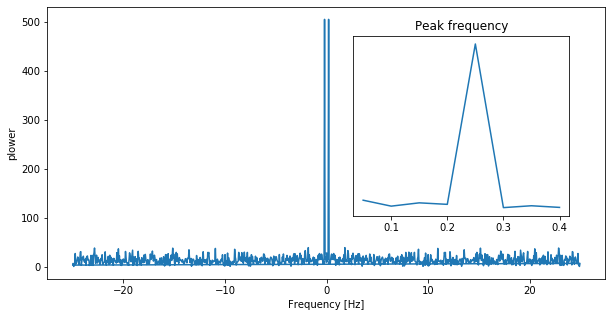

In [35]:
# The FFT of the signal
sig_fft = fftpack.fft(signal)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)

# The corresponding frequencies
sample_freq = fftpack.fftfreq(signal.size, d=time_step)

# Plot the FFT power
plt.figure(figsize=(10, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('plower')

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:8], power[:8])
plt.setp(axes, yticks=[])

# Check that it does indeed correspond to the frequency that we generate
# the signal with
print(np.allclose(peak_freq, 1./period))


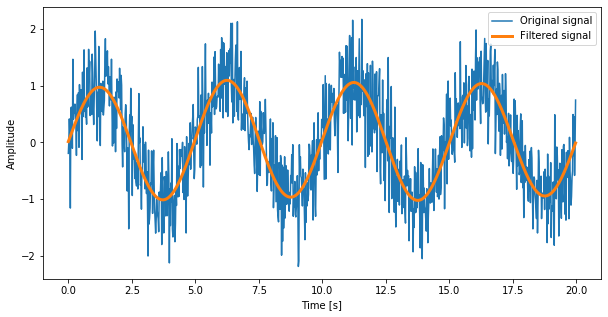

In [38]:
# Filtering high frequencies brutally
high_freq_fft = sig_fft.copy()
high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

plt.figure(figsize=(10, 5))
plt.plot(time_vec, signal, label='Original signal')
plt.plot(time_vec, filtered_sig, linewidth=3, label='Filtered signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.legend(loc='best')


### A few concepts

#### Power Spectral Density

##### Fourier Transform

$$ H(f) = \int_{-\infty}^{\infty} \; h(t) \; e^{-2\pi i f t}dt $$
$$ h(f) = \int_{-\infty}^{\infty} \; H(f) \; e^{-2\pi i f t}df $$

$$\mathrm{PSD}(f) \equiv \| H(f) \|^2 + \| H(-f) \|^2 $$

the **power spectral density** defined above measures the amount of power contained in the frequency interval between $f$ and $f+df$.

#### Convolution

$$ (a \star b)(t) \equiv \int_{-\infty}^\infty \; a(t') b(t-t') dt' $$
$$ h = a\star b \Rightarrow H(f) = A(f) B(f) $$ 

#### Nyquist Sampling Theorem and Aliasing

For discrete time we have a **discrete fourier transform**, and since this is a very time consuming operation, the algorith for calculating became known, which is the **fast fourier transform**.

$$H_k = \sum_{j=0}^{N-1} h_j e^{-\frac{2 \pi i j k}{N}}$$
$$h_j = \frac{1}{N} \sum_{j=0}^{N-1} H_k e^{-\frac{2 \pi i j k}{N}}$$

- A function h[t] of a discrete time variable is called **band limited** if  its Fourier transform is zero for frequencies higher than a certain maximum frequency $|H(f) = 0|$ if $|f|>f_c$.  This frequency is called **Nyquist critical frequency**. 
- **Nyquist theorem** states that, if h(t) is band limited with critical frequency $f_c$, there is a resolution limit in t space, $t_c = 1/(2 f_c$ below which h(t) appears smooth and h(t) can be exactly reconstructed from evenly sampled data.
- The reconstruction is done via the form known as **Whittaker-Shannon** sinc-shifting formula.
- The discrete analog of Power Spectral Density is:
$$ \mathrm{PSD}(f_k) = (\Delta t)^2 (|H_k|^2 + |H_{N-k}|^2) $$

**Reference:**
1. Elegant Scipy (https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html)
2. https://github.com/AllenDowney/ThinkDSP/tree/master/code
3. https://longbaonguyen.github.io/courses/dft/discrete_fourier.html

**Note:** Most of the material follows closely the first reference.